In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import re

## General data organization

In [33]:
df = pd.read_csv("student_responses.csv")

# rename column headers to be more succinct
df.columns = ["Timestamp",
              "Course",                             # Q1
              "Learned about comp bio how?",        # Q2
              "Courses w/ comp bio",                # Q3
              "Time on comp bio",                   # Q4
              "Instructor support",                 # Q5
              "Course resource support",            # Q6
              "Most helpful",                       # Q7
              "Frustrations",                       # Q8
              "Add. info",                          # Q9
              "Graduating",                         # Q10
              "Job app/acceptance impact",          # Q11
              "Career plan impact",                 # Q12
              "Demographics",                       # Q13
              "Email"]                              # Q14

df.insert(0, "ID", df.index, False)

Each respondent's unique identifier is the corresponding row's index.

## Individual questions
### Question 1
Standardize course codes:

In [34]:
# regexes to look for
subject_pattern = re.compile("[A-Za-z]{4}")         # e.g., "BSCI" or "BIOE"
number_pattern = re.compile("[0-9]{3}[A-Za-z]?")    # e.g., "171" or "330"

# iterate through each response in "Course" column and standardize course codes
for i in range(len(df["Course"])):
    subject = subject_pattern.search(df["Course"][i]).group().upper() if subject_pattern.search(df["Course"][i]) else ""
    number = number_pattern.search(df["Course"][i]).group().upper() if number_pattern.search(df["Course"][i]) else ""

    df.at[i, "Course"] = subject + number   # update course code to standard (e.g., biol708w -> BIOL708W)

Generate bar chart of course data:

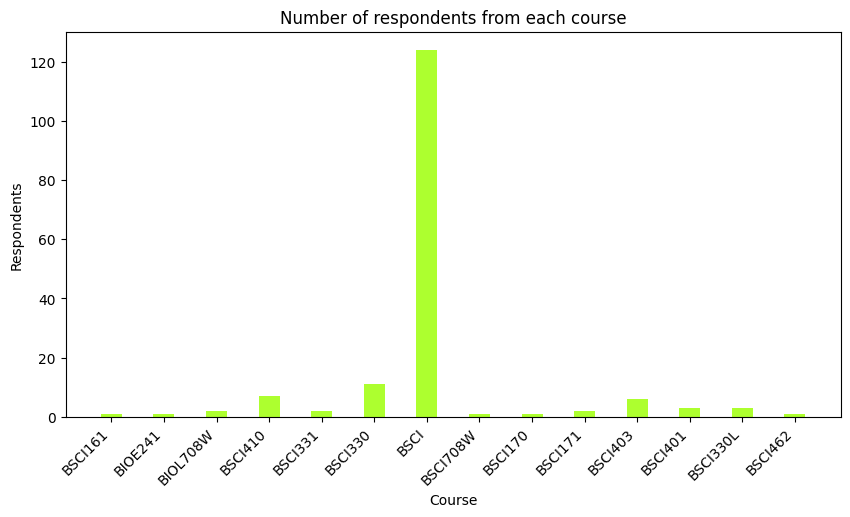

In [35]:
fig = plt.figure(figsize=(10, 5))

plt.bar(list(set(df["Course"])), df.groupby("Course").size(), color="greenyellow", width=0.4)
plt.xlabel("Course")
plt.ylabel("Respondents")
plt.title("Number of respondents from each course")
plt.xticks(rotation=45, ha="right")

plt.show()